In [3]:
from astropy.io import fits
from astropy import wcs
import matplotlib.pyplot as pl
from glob import glob
import numpy as np
import scipy.optimize as opt
import os


filters=['f555w','f814w','f125w','f160w']
# non-saturated stars near the corners of the WF3IR FOV

region="off"
positions=[[85.2605501,-69.7847356],
           [85.2312908,-69.8056414],
           [85.2749409,-69.8229753],
           [85.3017471,-69.8064283]]

# autoset catalog path based on user
if os.environ['USER'] =='remy':
    workdir="/Users/remy/cv/magellanic/n159/"

os.chdir(workdir+region+"/")

In [4]:
d=7
x = y = np.arange(-d,d)
X, Y = np.meshgrid(x, y)

# https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

def twoD_Gaussian(xy, amplitude, sigma, offset):
    a = 1/(2*sigma**2)
    c = 1/(2*sigma**2)
    g = offset + amplitude*np.exp( - (a*(xy[0]**2) + c*(xy[1]**2)))
    return g.ravel()

1 f555w -1.2055270425613106e-05 -7.177774011805076e-06
1 f814w -4.185525413752647e-06 3.886594844568957e-06
1 f125w -1.8910439306494045e-05 -1.6032263326654593e-07
1 f160w -1.7698949915585192e-05 -1.4879436414703127e-05
2 f555w 6.692409324038833e-07 3.657006492329094e-07
2 f814w -8.647133215602981e-07 -2.3468361485583095e-06
2 f125w -4.437244522043842e-06 7.996751281237336e-06
2 f160w -3.073919738243923e-06 1.5047929979484002e-05
3 f555w -1.6485075040049955e-05 -7.951944220601146e-07
3 f814w -5.914019062913936e-06 -3.3401291215380528e-06
3 f125w -5.274838109626721e-06 -1.1270311804541758e-05
3 f160w -1.178300594036987e-06 -3.902045174044957e-06
4 f555w -5.680404100677457e-06 -1.8940416475347365e-05
4 f814w -1.0048066178356922e-05 -1.8784917457088144e-05
4 f125w -3.615722747549442e-05 -7.477275798026389e-06
4 f160w -3.0009424710040333e-05 -2.634709796332511e-06


<Figure size 432x288 with 0 Axes>

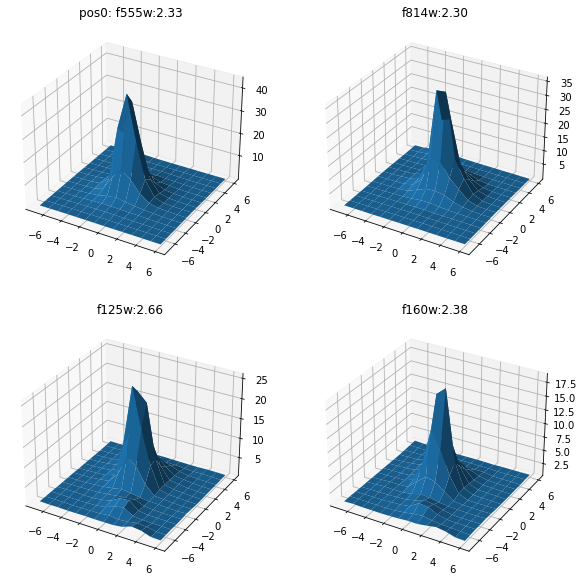

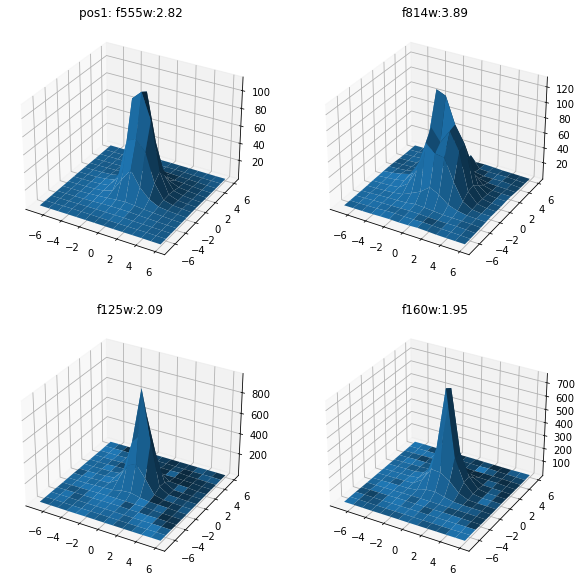

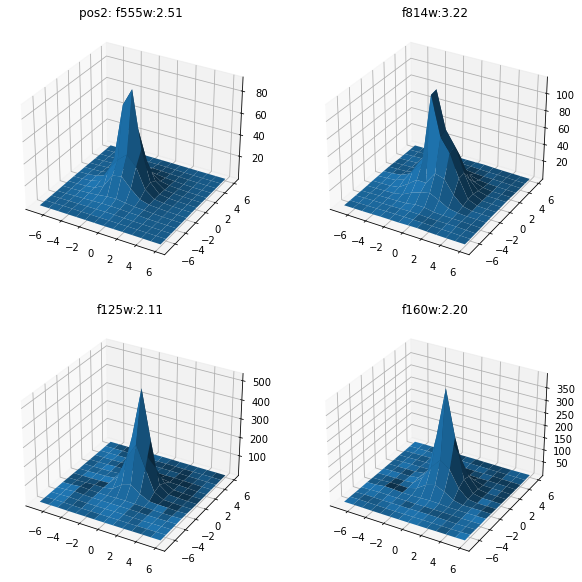

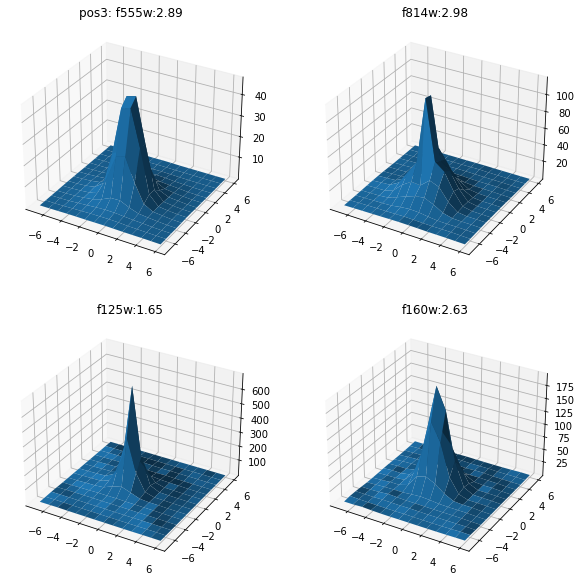

In [6]:
pl.subplots_adjust(hspace=0.25)
for j,pos in enumerate(positions):
    pl.figure(figsize=(10,10))
    
    for i,f in enumerate(filters):
        if 'f1' in f:
            camera="IR"
            kind="drz"
        else:
            camera="UVO"
            kind="drc"
        ax = pl.subplot(2,2,i+1, projection='3d')
        hdu=fits.open(glob(f+"/"+f+"_"+kind+"_sci.fits")[0])[0]
        thiswcs=wcs.WCS(hdu.header)
        xy=thiswcs.wcs_world2pix([pos],0)[0]
        xy=[int(np.round(x)) for x in xy]
        # todo recenter
        Z=hdu.data[xy[1]-d:xy[1]+d,xy[0]-d:xy[0]+d]
        ax.plot_surface(X, Y, Z)
        x0=(Z*X).sum()/Z.sum()
        y0=(Z*Y).sum()/Z.sum()
        term1x = (Z* X**2).sum()
        term2x = (Z* X).sum()**2 / Z.sum()
        mom2x = np.sqrt((term1x - term2x)/Z.sum())
        term1y = (Z* Y**2).sum()
        term2y = (Z* Y).sum()**2 / Z.sum()
        mom2y = np.sqrt((term1y - term2y)/Z.sum())
        dx=thiswcs.proj_plane_pixel_scales()[0].to("deg").value
        print(j+1,f,x0*dx,y0*dx)
        ax.set_title(f+":%4.2f"%(2.355*np.sqrt(mom2x**2+mom2y**2)))

        # amp, sigma, offset
        popt, pcov = opt.curve_fit(twoD_Gaussian, [X-x0,Y-y0], Z.ravel(), p0 = [Z.max(),1,0] )
        # print(popt)
        if i==0:
            ax.set_title(("pos%i: "%j)+f+":%4.2f"%(2.355*popt[1]))
        else:
            ax.set_title(f+":%4.2f"%(2.355*popt[1]))

        
    pl.savefig("checkpsf."+region+".pos%i.png"%j)
